In [ ]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.metrics import confusion_matrix, accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import h5py
import timm

: 

In [ ]:
# Referred to Midterm template, and GPT
class BRATS2020Dataset(Dataset):
    """
    Dataset class for BRATS2020 .h5 files. 
    Assumes each .h5 file contains 'image' and 'mask' keys.
    """

    def __init__(self, root_dir, n_sample=None, image_size=(224, 224), mask_size=(224, 224)):
        """
        Args:
            root_dir (str): Root directory with .h5 files.
            n_sample (int, optional): Number of samples to use. Defaults to all.
            image_size (tuple): Target image size.
            mask_size (tuple): Target mask size.
        """
        self.root_dir = root_dir
        self.file_paths = sorted(glob.glob(os.path.join(root_dir, '*.h5')))

        if n_sample and n_sample < len(self.file_paths):
            self.file_paths = self.file_paths[:n_sample]

        self.n_sample = len(self.file_paths)

        self.img_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.ConvertImageDtype(torch.float32),
            transforms.Resize(image_size),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

        self.msk_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(mask_size, interpolation=transforms.InterpolationMode.NEAREST)
        ])

    def __len__(self):
        return self.n_sample

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        with h5py.File(file_path, 'r') as f:
            image = np.array(f['image'])  # Assume shape (H, W)
            mask = np.array(f['mask'])    # Assume shape (H, W, C) or (H, W)

            # Optional channel weighting (0.1 for background class) #GPT referred here
            if mask.ndim == 3:
                mask = np.concatenate([np.ones((*mask.shape[:2], 1)) * 0.1, mask], axis=-1)
                mask = np.argmax(mask, axis=-1)

        image = self.img_transform(image)
        mask = self.msk_transform(mask).squeeze(0).long()

        return {
            'image': image,
            'mask': mask,
            'filename': os.path.basename(file_path)
        }
        

torch.Size([4, 224, 224]) torch.Size([224, 224]) volume_100_slice_107.h5
Image shape: (240, 240, 4), Mask shape: (240, 240, 3)


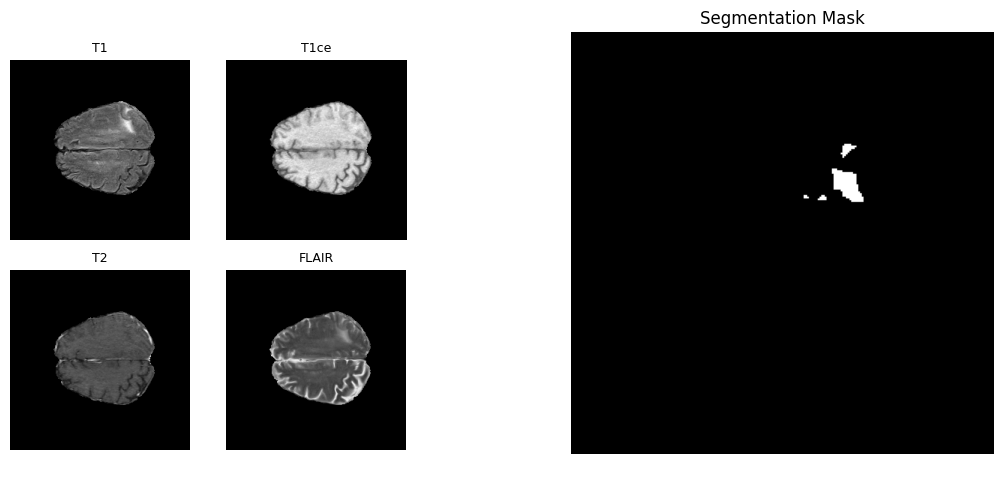

In [ ]:
data_dir = '/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data'
dataset = BRATS2020Dataset(data_dir, n_sample=10000)
sample = dataset[10]
print(sample['image'].shape, sample['mask'].shape, sample['filename'])

# Load the image and mask
file_path = os.path.join(data_dir, sample['filename'])
with h5py.File(file_path, 'r') as f:
    image = np.array(f['image'])         # Shape: (H, W)
    mask = np.array(f['mask'])           # Shape: (H, W) or (H, W, C)

    print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")

    # If mask has multiple channels (e.g., 3-class one-hot), take argmax (GPT referred here)
    if mask.ndim == 3:
        mask_display = np.argmax(mask, axis=-1)
    else:
        mask_display = mask


# GPT referred for plotting
# Modality labels
modality_names = ['T1', 'T1ce', 'T2', 'FLAIR']

# Create figure with 2 main panels
fig = plt.figure(figsize=(12, 6))

# Subplot 1: 2x2 grid for the 4 modalities
grid_ax = plt.subplot(1, 2, 1)
grid_ax.axis('off')  # Hide the outer subplot (acts as container)

# 2x2 grid of subplots within subplot 1
for i in range(4):
    row = i // 2
    col = i % 2
    ax = fig.add_axes([0.08 + col*0.18, 0.15 + (1 - row)*0.35, 0.15, 0.3])  # [left, bottom, width, height]
    ax.imshow(image[:, :, i], cmap='gray')
    ax.set_title(modality_names[i], fontsize=9)
    ax.axis('off')
ax_mask = plt.subplot(1, 2, 2)
ax_mask.imshow(mask_display, cmap='gray')
ax_mask.set_title('Segmentation Mask')
ax_mask.axis('off')
plt.show()

In [10]:
train_ratio = 0.7
test_ratio = 0.1
val_ratio = 1- train_ratio - test_ratio
train_size = int(train_ratio * len(dataset)) 
val_size = int(test_ratio * len(dataset))  
test_size = len(dataset) - train_size - val_size  

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
batch_size= 16
train_loader= DataLoader(train_dataset, batch_size= batch_size, shuffle= True)
val_loader= DataLoader(val_dataset, batch_size= batch_size, shuffle = False)
test_loader= DataLoader(test_dataset, batch_size= batch_size, shuffle= False)

In [ ]:
#Reference: Swin paper for pretrained weights and GPT help for decoder
#the output channels from the encider Swin Transformer have been matched with decoder

class DecoderBlock(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch):
        super(DecoderBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        self.conv = nn.Sequential(
            nn.Conv2d(out_ch + skip_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, skip):
        x = self.up(x)
        if x.shape[-2:] != skip.shape[-2:]:
            skip = F.interpolate(skip, size=x.shape[-2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

class SwinUNet2D(nn.Module):
    def __init__(self, num_classes=4, in_channels=4, backbone='swin_base_patch4_window7_224'):
        super(SwinUNet2D, self).__init__()

        # Swin Transformer Encoder
        self.encoder = timm.create_model(
            backbone,
            pretrained=True,
            features_only=True,
            in_chans=in_channels
        )
        encoder_channels = self.encoder.feature_info.channels()  # e.g., [128, 256, 512, 1024]

        # Decoder
        self.decoder4 = DecoderBlock(in_ch=encoder_channels[3], skip_ch=encoder_channels[2], out_ch=512)
        self.decoder3 = DecoderBlock(in_ch=512, skip_ch=encoder_channels[1], out_ch=256)
        self.decoder2 = DecoderBlock(in_ch=256, skip_ch=encoder_channels[0], out_ch=128)
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # Final prediction
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        enc_feats = self.encoder(x)  # List: [res2, res3, res4, res5]

        d4 = self.decoder4(enc_feats[3], enc_feats[2])
        d3 = self.decoder3(d4, enc_feats[1])
        d2 = self.decoder2(d3, enc_feats[0])
        d1 = self.decoder1(d2)
        out = self.final_conv(d1)
        return out  # (B, num_classes, H, W)

my_UNet = SwinUNet2D(num_classes=4, in_channels=4).cuda()


In [6]:
print(my_UNet)

SwinUNet2D(
  (encoder): FeatureListNet(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(1, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (layers_0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU(approximate='none'

Image shape: torch.Size([16, 4, 224, 224])
Mask shape: torch.Size([16, 224, 224])
Prediction shape: torch.Size([16, 4, 224, 224])


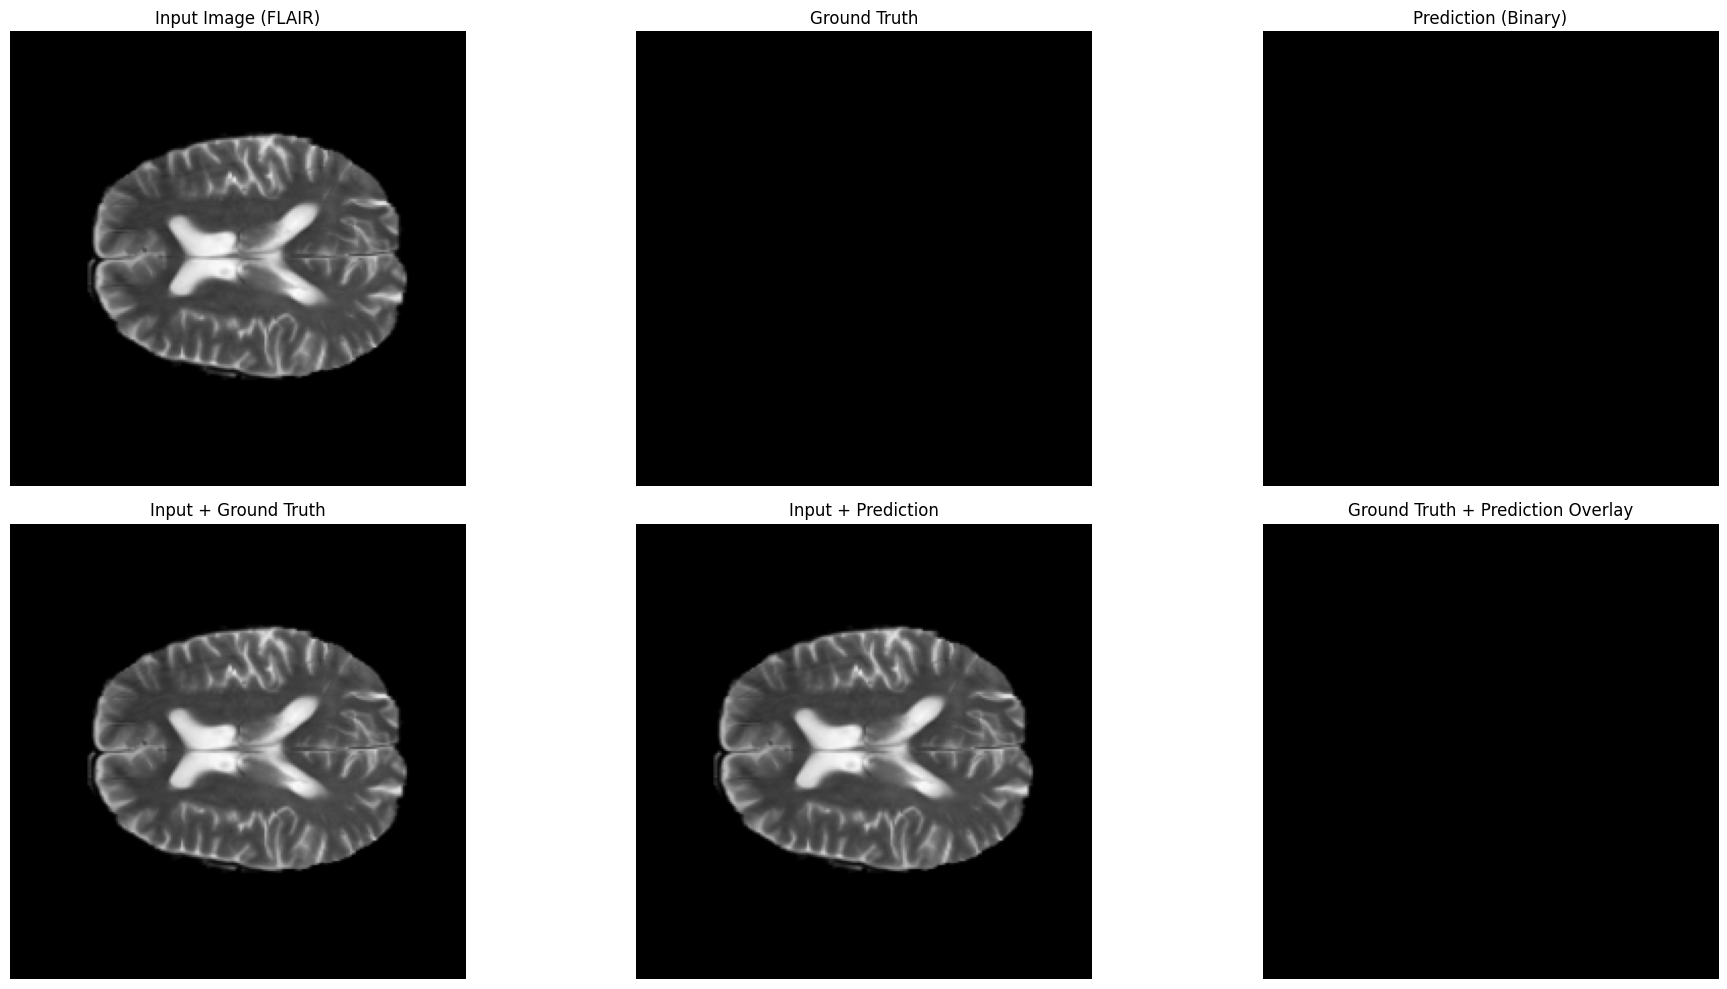

In [28]:
for batch in test_loader:
    sample_batch = batch
    break  # just one sample

# Inference
with torch.no_grad():
    input_img = sample_batch['image'].cuda()  # shape: [1, 4, H, W]
    y_pred = my_UNet(input_img)

# Print shapes
print('Image shape:', sample_batch['image'].shape)
print('Mask shape:', sample_batch['mask'].shape)
print('Prediction shape:', y_pred.shape)

# Get grayscale image for visualization — e.g., FLAIR (channel 3) of sample 0
img = sample_batch['image'][0, 3].cpu().numpy()  # shape: (256, 256)
img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]
img = (img * 255).astype('uint8')  # Convert to uint8 for display

# Ground truth mask for sample 0
msk = sample_batch['mask'][0].cpu().numpy()  # shape: (256, 256)
msk_bin = (msk > 0).astype('uint8') * 255  # Binary version for overlaying

# Prediction for sample 0
pred_softmax = torch.softmax(y_pred, dim=1)  # shape: [16, 4, 256, 256]
pred_class = torch.argmax(pred_softmax, dim=1)[0].cpu().numpy()  # shape: (256, 256)
pred_bin = (pred_class > 0).astype('uint8') * 255  # Binary for overlay

plt.figure(figsize=(20, 10))

plt.subplot(2,3,1)
plt.title('Input Image (FLAIR)')
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(2,3,2)
plt.title('Ground Truth')
plt.imshow(msk_bin, cmap='gray')
plt.axis('off')

plt.subplot(2,3,3)
plt.title('Prediction (Binary)')
plt.imshow(pred_bin, cmap='gray')
plt.axis('off')

# Overlay GT on input
img_overlay_gt = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img_overlay_gt[msk_bin == 255] = [0, 255, 0]

plt.subplot(2,3,4)
plt.title('Input + Ground Truth')
plt.imshow(img_overlay_gt)
plt.axis('off')

# Overlay Pred on input
img_overlay_pred = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img_overlay_pred[pred_bin == 255] = [255, 0, 0]

plt.subplot(2,3,5)
plt.title('Input + Prediction')
plt.imshow(img_overlay_pred)
plt.axis('off')

# Overlay both
combined = cv2.cvtColor(np.zeros_like(img), cv2.COLOR_GRAY2RGB)
combined[msk_bin == 255, 1] = 255  # green
combined[pred_bin == 255, 0] = 255  # red

plt.subplot(2,3,6)
plt.title('Ground Truth + Prediction Overlay')
plt.imshow(combined)
plt.axis('off')

plt.tight_layout()
plt.show()

In [29]:
#model= my_UNet.to(device)
#loss function
loss_function= torch.nn.CrossEntropyLoss() #binary cross entropy loss
#optimizer
optimizer= torch.optim.Adam(my_UNet.parameters(), lr= 0.001) #adaptive moment estimation

In [ ]:
def dice_coeff_multiclass(y_pred, y_true, num_classes=4, eps=1e-6):
    dices = []
    for cls in range(1, num_classes):  # skip background
        pred_cls = (y_pred == cls).float()
        true_cls = (y_true == cls).float()
        pred_sum = torch.sum(pred_cls)
        true_sum = torch.sum(true_cls)
        if pred_sum + true_sum == 0:
            continue  # skip class with no pixels in both pred and GT
        inter = torch.sum(pred_cls * true_cls)
        union = pred_sum + true_sum
        dice = (2 * inter + eps) / (union + eps)
        dices.append(dice.item())
    return np.mean(dices) if len(dices) > 0 else 0.0
    
def jaccard_coeff_multiclass(y_pred, y_true, num_classes=4, eps=1e-6):
    jaccards = []
    for cls in range(1, num_classes):
        pred_cls = (y_pred == cls).float()
        true_cls = (y_true == cls).float()
        pred_sum = torch.sum(pred_cls)
        true_sum = torch.sum(true_cls)
        if pred_sum + true_sum == 0:
            continue  # skip class with no activity
        inter = torch.sum(pred_cls * true_cls)
        union = pred_sum + true_sum - inter
        jaccard = (inter + eps) / (union + eps)
        jaccards.append(jaccard.item())
    return np.mean(jaccards) if len(jaccards) > 0 else 0.0
    

# The training function
def train_net(net, epochs, train_dataloader, valid_dataloader, optimizer, loss_function):
    
    if not os.path.isdir('{0}'.format(net.name)):
        os.mkdir('{0}'.format(net.name))
    
    n_train = len(train_dataloader)
    n_valid = len(valid_dataloader)    
    
    train_loss = list()
    valid_loss = list()
    train_dice = list()
    valid_dice = list()
    train_jaccard = list()
    valid_jaccard = list()
    
    for epoch in range(epochs):
        
        ################################################################################################################################
        ########################################################### Training ###########################################################
        ################################################################################################################################
        net.train()
        train_batch_loss = list()
        train_batch_dice = list()
        train_batch_jaccard = list()
        
        for i, batch in enumerate(train_dataloader):
            imgs = batch['image'].cuda()
            true_masks = batch['mask'].cuda()
            y_pred = net(imgs)
            loss = loss_function(y_pred, true_masks)
            batch_loss = loss.item()
            train_batch_loss.append(batch_loss)
            pred_class = torch.argmax(y_pred, dim=1)
            batch_dice_score = dice_coeff_multiclass(pred_class, true_masks)
            train_batch_dice.append(batch_dice_score)
            batch_jaccard_score = jaccard_coeff_multiclass(pred_class, true_masks)
            train_batch_jaccard.append(batch_jaccard_score)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Print the progress
            print(f'EPOCH {epoch + 1}/{epochs} - Training Batch {i+1}/{n_train} - Loss: {batch_loss}, DICE score: {batch_dice_score}, Jaccard score: {batch_jaccard_score}            ', end='\r')
        
        average_training_loss = np.array(train_batch_loss).mean()
        average_training_dice = np.mean(train_batch_dice) if train_batch_dice else 0.0
        average_training_jaccard = np.array(train_batch_jaccard).mean() if train_batch_jaccard else 0.0
        train_loss.append(average_training_loss)
        train_dice.append(average_training_dice)
        train_jaccard.append(average_training_jaccard)
        
        ################################################################################################################################
        ########################################################## Validation ##########################################################
        ################################################################################################################################
        
        net.eval()
        valid_batch_loss = list()
        valid_batch_dice = list()
        valid_batch_jaccard = list()
        
        # This part is almost the same as training with the difference that we will set all layers to evaluation mode (effects some layers such as BN and Dropout) and also
        with torch.no_grad():
            for i, batch in enumerate(valid_dataloader):
                imgs = batch['image'].cuda()
                true_masks = batch['mask'].cuda()
                y_pred = net(imgs)
                loss = loss_function(y_pred, true_masks)
                batch_loss = loss.item()
                valid_batch_loss.append(batch_loss)
                pred_class = torch.argmax(y_pred, dim=1)

                # Compute the DICE score for this batch and append it to the epoch dice
                batch_dice_score = dice_coeff_multiclass(pred_class, true_masks)
                valid_batch_dice.append(batch_dice_score)
                                
                # Compute the Jaccard score here and append the score to the list
                batch_jaccard_score = jaccard_coeff_multiclass(pred_class, true_masks)
                valid_batch_jaccard.append(batch_jaccard_score)

                # Print the progress
                print(f'EPOCH {epoch + 1}/{epochs} - Validation Batch {i+1}/{n_valid} - Loss: {batch_loss}, DICE score: {batch_dice_score}, Jaccard score: {batch_jaccard_score}            ', end='\r')
                
        average_validation_loss = np.array(valid_batch_loss).mean()
        average_validation_dice = np.array(valid_batch_dice).mean() if valid_batch_dice else 0.0
        average_validation_jaccard = np.array(valid_batch_jaccard).mean() if valid_batch_jaccard else 0.0
        valid_loss.append(average_validation_loss)
        valid_dice.append(average_validation_dice)
        valid_jaccard.append(average_validation_jaccard)
        
        print(f'EPOCH {epoch + 1}/{epochs} - Training Loss: {average_training_loss}, Training DICE score: {average_training_dice}, Training Jaccard score: {average_training_jaccard}, Validation Loss: {average_validation_loss}, Validation DICE score: {average_validation_dice}, Validation Jaccard score: {average_validation_jaccard}')

        ################################################################################################################################
        ###################################################### Saveing Checkpoints #####################################################
        ################################################################################################################################
        torch.save(net.state_dict(), f'{net.name}/epoch_{epoch+1:03}.pth')
    
    return train_loss, train_dice, train_jaccard, valid_loss, valid_dice, valid_jaccard

In [31]:
EPOCHS = 30
train_loss, train_dice, train_jaccard, valid_loss, valid_dice, valid_jaccard = train_net(my_UNet, EPOCHS, train_loader, val_loader, optimizer, loss_function)

EPOCH 1/30 - Training Loss: 0.010676875629953479, Training DICE score: 0.6005688316623391, Training Jaccard score: 0.4847578170822347, Validation Loss: 0.009868196873289962, Validation DICE score: 0.7158933879521788, Validation Jaccard score: 0.5753806991670183
EPOCH 2/30 - Training Loss: 0.008065656451061878, Training DICE score: 0.7491737118196571, Training Jaccard score: 0.6215420282465869, Validation Loss: 0.00970960200010311, Validation DICE score: 0.7307215122919944, Validation Jaccard score: 0.6004296651174112
EPOCH 3/30 - Training Loss: 0.007170712905558523, Training DICE score: 0.7820372761748815, Training Jaccard score: 0.6605073816142947, Validation Loss: 0.007145296087458966, Validation DICE score: 0.7883917636541543, Validation Jaccard score: 0.6727686971468348
EPOCH 4/30 - Training Loss: 0.0070843406353298935, Training DICE score: 0.7857301553236967, Training Jaccard score: 0.6661242238504445, Validation Loss: 0.007179861531652037, Validation DICE score: 0.796068045157919

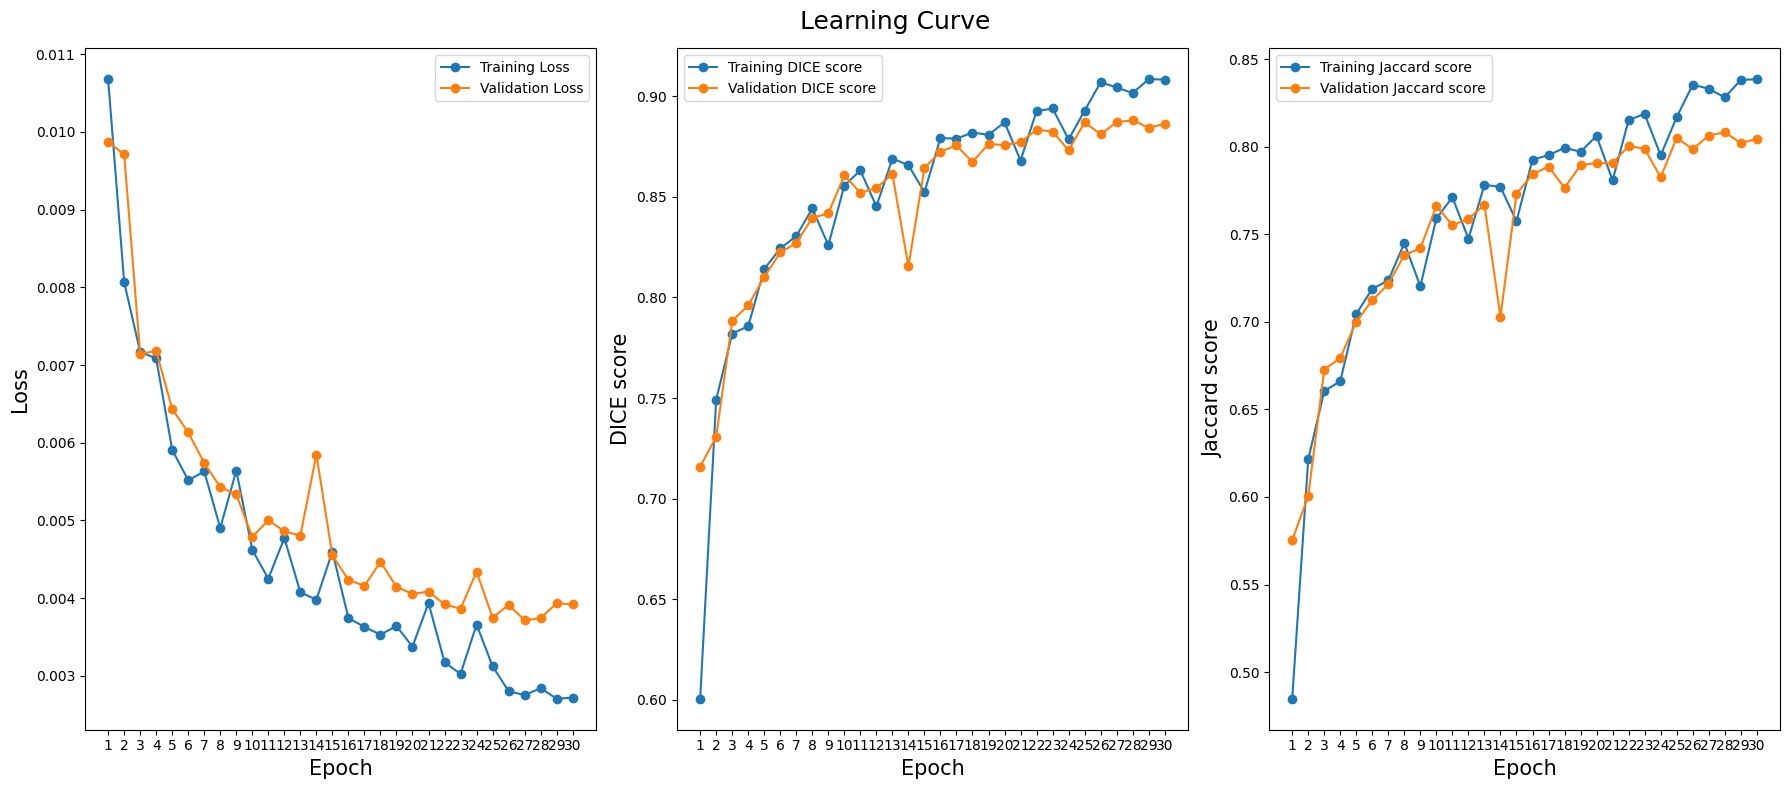

In [32]:
plt.figure(figsize=(18,8))
plt.suptitle('Learning Curve', fontsize=18)

plt.subplot(1,3,1)
plt.plot(np.arange(EPOCHS)+1, train_loss, '-o', label='Training Loss')
plt.plot(np.arange(EPOCHS)+1, valid_loss, '-o', label='Validation Loss')
plt.xticks(np.arange(EPOCHS)+1)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend()

plt.subplot(1,3,2)
plt.plot(np.arange(EPOCHS)+1, train_dice, '-o', label='Training DICE score')
plt.plot(np.arange(EPOCHS)+1, valid_dice, '-o', label='Validation DICE score')
plt.xticks(np.arange(EPOCHS)+1)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('DICE score', fontsize=15)
plt.legend()

plt.subplot(1,3,3)
plt.plot(np.arange(EPOCHS)+1, train_jaccard, '-o', label='Training Jaccard score')
plt.plot(np.arange(EPOCHS)+1, valid_jaccard, '-o', label='Validation Jaccard score')
plt.xticks(np.arange(EPOCHS)+1)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Jaccard score', fontsize=15)
plt.legend()

plt.tight_layout()
plt.show()

Sample batch "image" shape: torch.Size([16, 4, 224, 224])
Sample batch "mask" shape: torch.Size([16, 224, 224])
Predicted mask shape: torch.Size([16, 4, 224, 224])


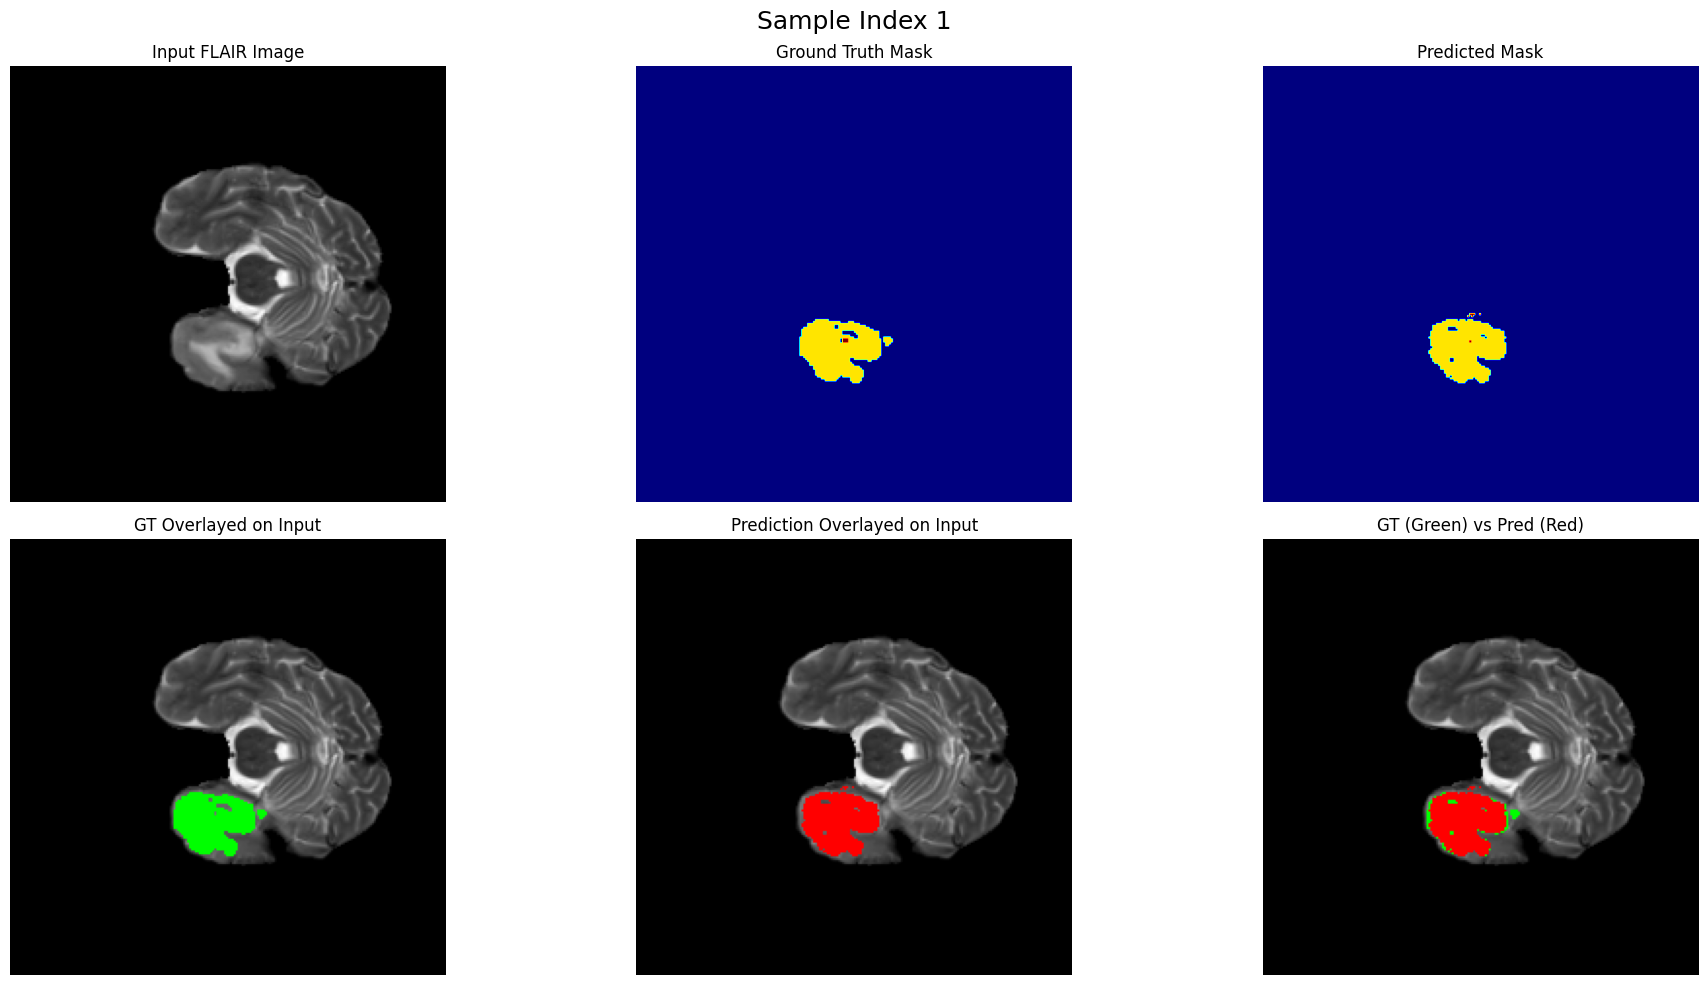

In [ ]:
for batch in test_loader:
    sample_batch = batch
    break

# Generate network prediction
with torch.no_grad():
    y_pred = my_UNet(sample_batch['image'].cuda())

# Print the shapes of the images, masks, predicted masks
print('Sample batch "image" shape:', sample_batch['image'].shape)
print('Sample batch "mask" shape:', sample_batch['mask'].shape)
print('Predicted mask shape:', y_pred.shape)
i = 1 
img = sample_batch['image'][i, 3].cpu().numpy()
img = (img - img.min()) / (img.max() - img.min())  
img = (img * 255).astype('uint8')  
msk = sample_batch['mask'][i].cpu().numpy()
msk_vis = (msk > 0).astype('uint8') * 255  

# Prediction mask
pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)[i].cpu().numpy()
pred_vis = (pred_class > 0).astype('uint8') * 255  
# Overlay masks on input image
img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
overlay_gt = img_rgb.copy()
overlay_gt[msk_vis == 255] = [0, 255, 0]  

overlay_pred = img_rgb.copy()
overlay_pred[pred_vis == 255] = [255, 0, 0]  

overlay_both = img_rgb.copy()
overlay_both[msk_vis == 255] = [0, 255, 0]
overlay_both[pred_vis == 255] = [255, 0, 0]

# Plot the results
plt.figure(figsize=(20, 10))
plt.suptitle(f'Sample Index {i}', fontsize=18)

plt.subplot(2, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Input FLAIR Image')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(msk, cmap='jet')
plt.title('Ground Truth Mask')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(pred_class, cmap='jet')
plt.title('Predicted Mask')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(overlay_gt)
plt.title('GT Overlayed on Input')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(overlay_pred)
plt.title('Prediction Overlayed on Input')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(overlay_both)
plt.title('GT (Green) vs Pred (Red)')
plt.axis('off')

plt.tight_layout()
plt.show()

In [37]:
#Testing Loop: Baseline reference- Midterm notebook
def test_net(net, test_dataloader, loss_function, save_dir='/kaggle/working/pred_mask', class_labels=[0, 1, 2, 4]):
    import os
    from sklearn.metrics import confusion_matrix, accuracy_score

    os.makedirs(save_dir, exist_ok=True)
    
    net.eval()
    
    test_batch_loss = []
    test_batch_dice = []
    test_batch_jaccard = []
    test_batch_accuracy = []
    test_batch_CM = []

    with torch.no_grad():
        for i, batch in enumerate(test_dataloader):
            imgs = batch['image'].cuda()             # [B, 4, H, W]
            true_masks = batch['mask'].cuda()        # [B, H, W]
            filenames = batch.get('filename', [f'{i}_{j}.png' for j in range(imgs.shape[0])])  # fallback

            # Forward pass
            y_pred = net(imgs)                       # [B, C, H, W]

            # Loss
            loss = loss_function(y_pred, true_masks)
            test_batch_loss.append(loss.item())

            # Predictions
            pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)  # [B, H, W]

            # DICE & Jaccard (multiclass)
            dice = dice_coeff_multiclass(pred_class, true_masks)
            jaccard = jaccard_coeff_multiclass(pred_class, true_masks)
            test_batch_dice.append(dice)
            test_batch_jaccard.append(jaccard)

            # Accuracy & Confusion Matrix
            flat_true = true_masks.view(-1).cpu().numpy()
            flat_pred = pred_class.view(-1).cpu().numpy()
            acc = accuracy_score(flat_true, flat_pred)
            cm = confusion_matrix(flat_true, flat_pred, labels=class_labels, normalize='true')

            test_batch_accuracy.append(acc)
            test_batch_CM.append(cm)

            # Save predictions
            for k in range(pred_class.shape[0]):
                filename = os.path.splitext(os.path.basename(filenames[k]))[0]
                pred_np = pred_class[k].cpu().numpy().astype('uint8')
                save_path = os.path.join(save_dir, f'{filename}_pred.png')
                cv2.imwrite(save_path, pred_np)

            # Progress
            print(f'[TEST] Batch {i+1}/{len(test_dataloader)} - Loss: {loss.item():.4f}, Dice: {dice:.4f}, Jaccard: {jaccard:.4f}, Acc: {acc:.4f}', end='\r')

    # Aggregate metrics
    test_loss = np.mean(test_batch_loss)
    test_dice = np.mean(test_batch_dice)
    test_jaccard = np.mean(test_batch_jaccard)
    test_accuracy = np.mean(test_batch_accuracy)
    test_CM = np.mean(test_batch_CM, axis=0)

    return test_loss, test_dice, test_jaccard, test_accuracy, test_CM

Test Loss: 0.003795565883629024, Test DICE score: 0.8898423617482184, Test Jaccard score: 0.808943710098664, Test overall accuracy: 0.9985737404336735
------------------------------------------------------------------------------------------------------------------------------------


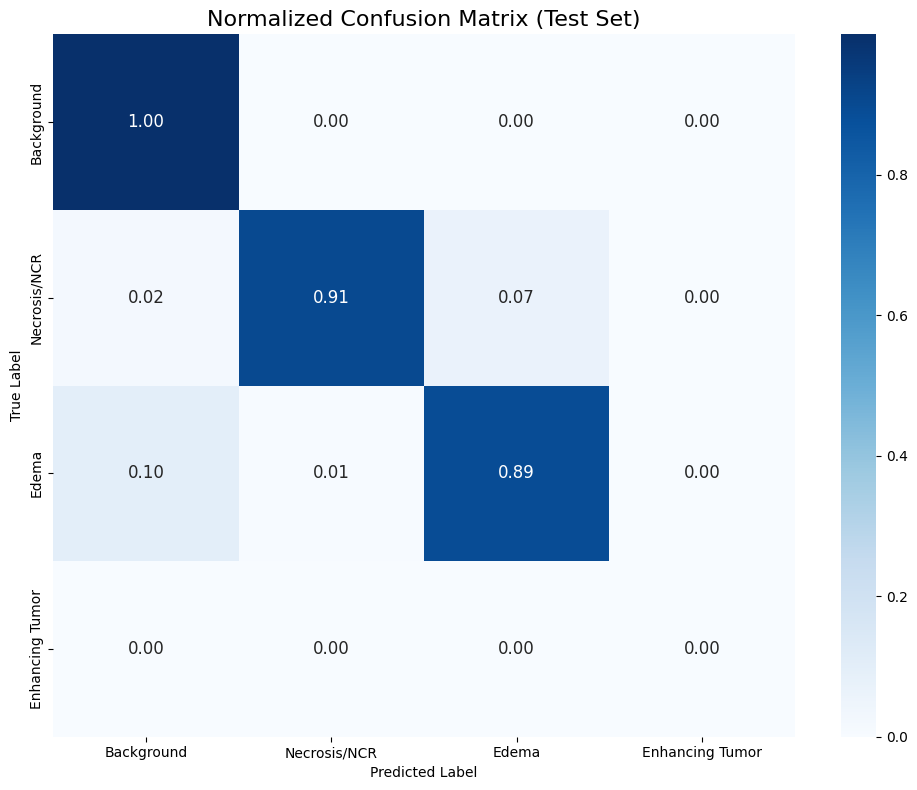

In [38]:
# Reference: Midterm Notebook
test_loss, test_dice, test_jaccard, test_accuracy, test_CM = test_net(my_UNet, test_loader, loss_function)

print(f'Test Loss: {test_loss}, Test DICE score: {test_dice}, Test Jaccard score: {test_jaccard}, Test overall accuracy: {test_accuracy}')
print('------------------------------------------------------------------------------------------------------------------------------------')

# BraTS label meaning
class_labels = [0, 1, 2, 4]
class_names = ['Background', 'Necrosis/NCR', 'Edema', 'Enhancing Tumor']

# Create confusion matrix DataFrame
df_cm = pd.DataFrame(test_CM, index=class_names, columns=class_names)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap='Blues', annot_kws={"size": 12})
plt.title('Normalized Confusion Matrix (Test Set)', fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()